# Example of one way you might detect and quantify objects in the image

<IPython.core.display.Javascript object>


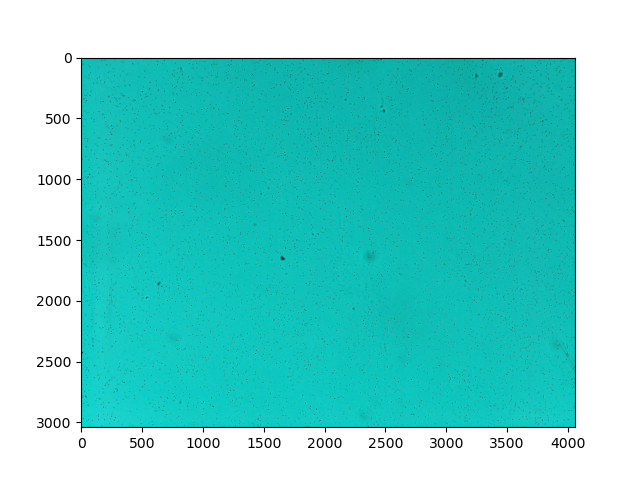

In [42]:
%matplotlib notebook
import numpy as np
import pandas as pd
import math
from skimage import io, color, util, exposure, feature, morphology,measure
import matplotlib.pyplot as plt
import os
import scipy.ndimage as ndi
import cv2
from skimage.filters import sobel#, threshold_otsu, threshold_multiotsu


directory='images'
file='16_08_04_254765.jpg'
photo = io.imread(os.path.join(directory,file))

plt.figure()
plt.imshow(photo)



# Convert the image to greyscale.
## Here I use the HSV "Value" of the image (H=Hue, S=Saturation, V=Value).  There are other ways to get greyscale, for example color.rgb2grey

<IPython.core.display.Javascript object>


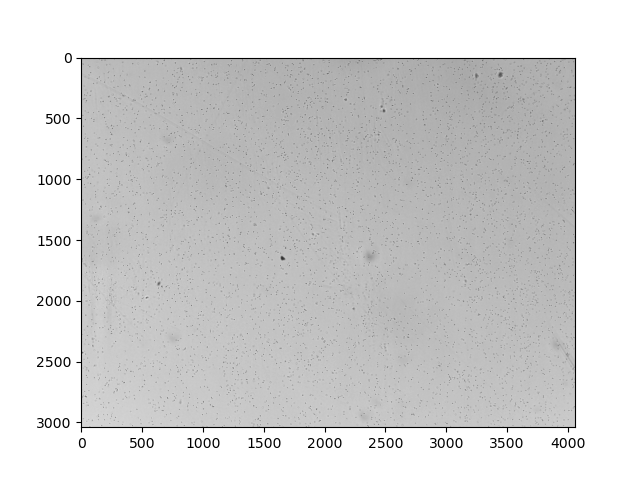

In [26]:
photo_hsv=color.rgb2hsv(photo)
photo_value=photo_hsv[:,:,2]

plt.figure()
plt.imshow(photo_value,cmap=plt.cm.gray)



# Reduce background noise using a Fast Fourier Transform
## This step may or may not make a difference for your images. It doesn't take too long to run though.

## If you want to mess around with these parameters, try altering the "sigma" value.

<IPython.core.display.Javascript object>


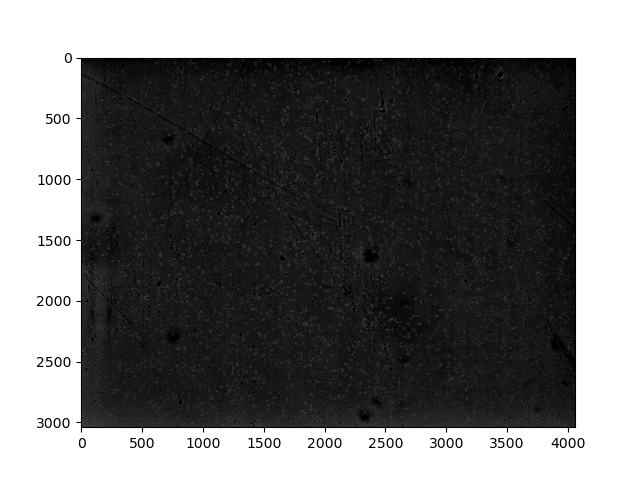

In [43]:
def fft_function(photo):
    sigma=4
    pad=100
    top_padding=np.array(np.zeros_like(photo[0:pad,:]))
    top_padding[:,:]=photo[0,:]
    bottom_padding=np.array(np.zeros_like(photo[0:pad,:]))
    bottom_padding[:,:]=photo[np.shape(photo)[0]-1,:]
    padded_photo=np.concatenate((top_padding,np.array(photo),bottom_padding))
    left_padding=np.array(np.zeros_like(padded_photo[:,0:pad]))
    left_padding=np.transpose(left_padding)
    left_padding[:,:]=padded_photo[:,0]
    left_padding=np.transpose(left_padding)
    right_padding=np.array(np.zeros_like(padded_photo[:,0:pad]))
    right_padding=np.transpose(right_padding)
    right_padding[:,:]=padded_photo[:,np.shape(photo)[1]-1]
    right_padding=np.transpose(right_padding)
    padded_photo=np.concatenate((left_padding,padded_photo,right_padding),axis=1)
    photo_dimensions=np.shape(padded_photo)
    nrows=photo_dimensions[1]
    ncols=photo_dimensions[0]
    cy, cx = ncols/2, nrows/2
    x = np.linspace(0, nrows, nrows)
    y = np.linspace(0, ncols, ncols)
    X, Y = np.meshgrid(x, y)
    gmask = np.exp(-(((X-cx)/sigma)**2 + ((Y-cy)/sigma)**2))
    photo_fft = np.fft.fft2(padded_photo) #disk shape over which median value is calculated must be larger than the largest particle
    photo_fft=np.fft.fftshift(photo_fft)
    blur_image=photo_fft*gmask
    blur_image_dimensions=np.shape(blur_image)
    photo_ifftshifted=np.fft.ifftshift(blur_image)
    photo_ifft = np.fft.ifft2(photo_ifftshifted)
    photo_ifft_trimmed=photo_ifft[pad:blur_image_dimensions[0]-pad,pad:blur_image_dimensions[1]-pad]
    photo_nobg=photo-np.abs(photo_ifft_trimmed)
    return(photo_nobg)


photo_grey_nobg=fft_function(photo_value)
photo_grey_nobg=util.img_as_ubyte(photo_grey_nobg)

plt.figure()
plt.imshow(np.abs(photo_grey_nobg),cmap=plt.cm.gray)




# Identify pixels that belong to potential particles (i.e. "markers")

## First identify them by simple brightness thresholding.  I standardize this threshold level so that it is some number of standard deviations above the mean pixel brightness of the image.  Here, I defined all pixels in the "marker" image to be white (255) if the corresponding pixels in the photo_grey_nobg image are 3 standard deviations above the mean pixel brightness.

## Next, help identify the full particle area by also detecting pixels associated with "edges" (i.e. large changes in pixel intensity over a short distance).  Here I am using the Canny edge detector.  If you want to mess with how edges are detected, try changing the thresholds of the Canny edge detector.  Here I chose 100 and 150 (see help documentation of this function for more info).

## Then fill in the holes.  Artificially "dilate" all your markers, fill in the holes again and then erode your markers to remove the extra area added by the dilation.  This extra step helps to detect the entire particle and fill it in completely.


<IPython.core.display.Javascript object>


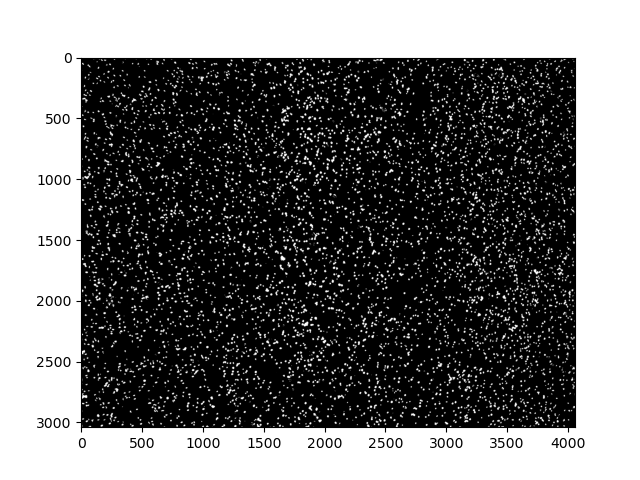

In [44]:
# Make an empty image, containing only zeros (i.e. black)
markers = np.zeros_like(photo_grey_nobg)
# Define which pixels are white based on the threshold fo the greyscale background-removed image
markers[photo_grey_nobg >=np.mean(photo_grey_nobg)+(3*np.std(photo_grey_nobg))] = 255


photo_canny=cv2.Canny(photo,100,150)
photo_particles=markers.copy()
photo_particles[photo_canny==255]=255
photo_particles_filled=ndi.morphology.binary_fill_holes(photo_particles)
photo_particles_filled1=morphology.dilation(photo_particles_filled, selem = morphology.disk(1))
photo_particles_filled1=ndi.morphology.binary_fill_holes(photo_particles_filled1)
photo_particles_filled2=morphology.erosion(photo_particles_filled1, selem = morphology.disk(1))

plt.figure()
plt.imshow(photo_particles_filled2,cmap=plt.cm.gray)

## Measure the properties of all the detected particles and write it into a dataframe.
## You will need to add the actual scale of the image.  (pixels per micron).  I made up a number here.

In [45]:
particle_image=util.img_as_ubyte(photo_particles_filled2)
labeled_particles,_ =ndi.label(particle_image)
properties = measure.regionprops(labeled_particles)

scale = 2 #Change this to the actual pixels per micron, or whatever units you want.
count=0
particle_area = []
particle_ESD = []
particle_perimeter = []
particle_major_axis= []
particle_minor_axis= []
particle_numberID = []
file_name = []
bounding_box = []

for x in properties:
    count = count +1
    px_area=x.area
    um_area = px_area / scale_area
    min_axis = x.minor_axis_length / scale
    maj_axis = x.major_axis_length / scale
    perim = x.perimeter / scale
    ESD = 2*(math.sqrt(um_area/math.pi))
    particle_perimeter.append(perim)
    particle_major_axis.append(maj_axis)
    particle_minor_axis.append(min_axis)
    particle_area.append(um_area)
    particle_ESD.append(ESD)
    particle_numberID.append(count)
    file_name.append(file)
    bounding_box.append(str([x.bbox[0],x.bbox[2],x.bbox[1],x.bbox[3]]))

data = pd.DataFrame(np.stack((particle_numberID, particle_area, particle_ESD, particle_minor_axis, particle_major_axis, particle_perimeter, file_name, bounding_box),-1),columns=['Number','Area','ESD','minor_length','major_length','perimeter','file_name', 'bounding_box'])


In [46]:
data


,Number,Area,ESD,minor_length,major_length,perimeter,file_name,bounding_box
0,1,837.5,32.654833007009834,3.1983324029276625,7.313380092917935,18.399494936611664,16_08_04_254765.jpg,"[0, 8, 78, 93]"
1,2,75.0,9.772050238058398,0.9428090415820636,1.9148542155126762,3.2071067811865475,16_08_04_254765.jpg,"[0, 2, 719, 723]"
2,3,37.5,6.90988298942671,0.6666666666666666,1.1547005383792517,1.7071067811865475,16_08_04_254765.jpg,"[0, 2, 724, 726]"
3,4,975.0,35.233628199729644,4.111772934350696,6.435537061857356,17.899494936611667,16_08_04_254765.jpg,"[0, 11, 810, 822]"
4,5,862.5,33.13863466309495,3.4240348451111586,6.815200500662964,17.071067811865476,16_08_04_254765.jpg,"[0, 7, 1115, 1128]"
...,...,...,...,...,...,...,...,...
8337,8338,12.5,3.989422804014327,0.0,0.0,0.0,16_08_04_254765.jpg,"[3039, 3040, 1639, 1640]"
8338,8339,12.5,3.989422804014327,0.0,0.0,0.0,16_08_04_254765.jpg,"[3039, 3040, 2076, 2077]"
8339,8340,50.0,7.978845608028654,0.0,2.23606797749979,1.0,16_08_04_254765.jpg,"[3039, 3040, 3338, 3342]"
8340,8341,12.5,3.989422804014327,0.0,0.0,0.0,16_08_04_254765.jpg,"[3039, 3040, 3346, 3347]"


## This image helps you sanity check afterward exactly what was counted.  This image has an outline drawn around each detected particle area, so you know if there is some bias (too large, missing lots of particles, etc.)

<IPython.core.display.Javascript object>


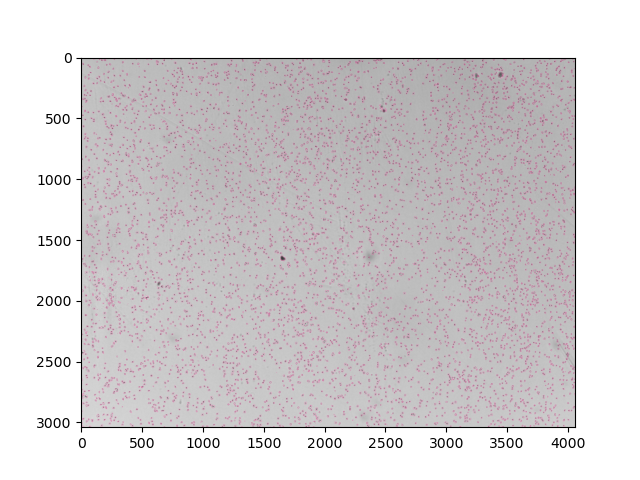

In [47]:
particle_edges=cv2.Canny(particle_image,100,200)
Value_color=util.img_as_ubyte(color.gray2rgb(photo_value))
Value_color[particle_edges==255]=[255,0,127]
plt.figure()
plt.imshow(Value_color)

# If for some reason you detect a lot of blurry or out of focus objects and you don't want them, let me know and I can show you how to filter those out too. It didn't seem like it was needed for an image like this.